In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import nipiezojenapy
import qt3utils.nidaq
import qt3utils.datagenerators as datasources
import qt3utils.datagenerators.piezoscanner
from argparse import Namespace
import matplotlib.pyplot as plt
import scipy.optimize

In [3]:
import qt3utils.nidaq.config

In [4]:
qt3utils.nidaq.config.reset_daq('Dev1')

In [5]:
logging.basicConfig(level = logging.INFO)
#logging.getLogger(qt3utils.datagenerators.piezoscanner.__name__).setLevel(logging.INFO)

In [6]:
args = Namespace(daq_name='Dev1', 
                 signal_terminal='PFI0', 
                 clock_rate=100000, 
                 num_data_samples_per_batch=50, 
                 clock_terminal=None, 
                 rwtimeout=10, 
                 signal_counter='ctr2', 
                 piezo_write_channels='ao0,ao1,ao2', 
                 piezo_read_channels='ai0,ai1,ai2', 
                 randomtest=False, 
                 cmap='Reds')

In [7]:
controller = nipiezojenapy.PiezoControl(device_name = args.daq_name,
                                  write_channels = args.piezo_write_channels.split(','),
                                  read_channels = args.piezo_read_channels.split(','))

In [8]:
data_acq = datasources.NiDaqSampler(args.daq_name,
                             args.signal_terminal,
                             args.clock_rate,
                             args.num_data_samples_per_batch,
                             args.clock_terminal,
                             args.rwtimeout,
                             args.signal_counter)

In [9]:
scanner = datasources.NiDaqPiezoScanner(data_acq, controller)

In [10]:
scanner.set_scan_range(0.01,40.01,0.01,40.01)

In [11]:
scanner.reset()

In [12]:
scanner.start()

INFO:nipiezojenapy.controller:go to position x: 0.01 y: 0.01


In [13]:
scanner.controller.get_current_position()

[-0.024685655065077045, -0.04658346316127078, -0.05302399495366178]

In [ ]:
some_optimal_z = 15 #use the qt3scope tool and the nipiezojenapy tool to find an optimal z
#OR, maybe can run a large optimize scan across all of z. see the optimize code below.
controller.go_to_position(z = some_optimal_z)

In [ ]:
while scanner.still_scanning():
            scanner.scan_x()
            scanner.move_y()

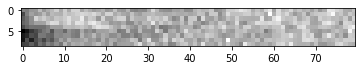

In [26]:
plt.imshow(scanner.data, cmap='gray', extent = [0.01, 
                                                40.01 + scanner.step_size, 
                                                40.01 + scanner.step_size, 
                                                0.01])

In [14]:
scanner.stop()

In [ ]:
#perform some computational magic to locate a position of interest.
#for example, perform a convolution of the image with a mask that
#represents your interest (for example, a single NV center that is 
#significantly isolated from other NV centers in the sample
#https://en.wikipedia.org/wiki/Kernel_(image_processing)

x_opt, y_opt = find_best_nv_center(scanner.data)

controller.go_to_position(x_opt, y_opt)

In [ ]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def optimize(axis, start_pos, opt_range = 2, step_size = 0.25):
    min_val = start_pos - opt_range
    max_val = start_pos + opt_range
    scanner.start()
    data = scanner.scan_axis(axis, min_val, max_val, step_size)
    scanner.stop()
    axis_vals = np.arange(min_val, max_val, step_size)

    optimal_position = axis_vals[np.argmax(data)]
    p0 = [np.max(data), optimal_position, 1.0]
    try:
        coeff, var_matrix = scipy.optimize.curve_fit(gauss, axis_vals, data, p0=p0)
        optimal_position = coeff[1]
    except RuntimeError as e:
        print(e)
        
    return optimal_position


In [ ]:
x_opt = optimize(axis = 'x', x_opt)
controller.go_to_position(x = x_opt)

y_opt = optimize(axis = 'y', y_opt)
controller.go_to_position(y = y_opt)

z_opt = optimize(axis = 'z', some_optimal_z)
controller.go_to_position(z = z_opt)

x_opt = optimize(axis = 'x', x_opt)
controller.go_to_position(x = x_opt)

y_opt = optimize(axis = 'y', y_opt)
controller.go_to_position(y = y_opt)


In [ ]:
data, scanvals, x_opt, fit_coef = scanner.optimize_position(axis = 'x', x_opt) #can set range and step size as well.
controller.go_to_position(x = x_opt)

data, scanvals, y_opt, fit_coef = scanner.optimize_position(axis = 'y', y_opt)
controller.go_to_position(y = y_opt)

data, scanvals, z_opt, fit_coef = scanner.optimize_position(axis = 'z', some_optimal_z)
controller.go_to_position(z = z_opt)

data, scanvals, x_opt, fit_coef = scanner.optimize_position(axis = 'x', x_opt)
controller.go_to_position(x = x_opt)

data, scanvals, y_opt, fit_coef = scanner.optimize_position(axis = 'y', y_opt)
controller.go_to_position(y = y_opt)